In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data95924


**解压数据集**

解压后共有三个文件夹，training，validation，还有一个test

In [ ]:
!unzip -o -q -d  /home/aistudio/work data/data95924/food-11.zip

#  项目背景

**生活中有各种各样的食物，利用计算机视觉，结合深度学习，让机器也能识别人类世界中的食物，还是挺有意思的。**

**项目基于飞桨图像分类套件PaddleClas，可以快速实现模型训练与预测。**

相关学习内容：[AI达人创造营](https://aistudio.baidu.com/aistudio/education/group/info/24607)

In [ ]:
#导入相关库
import os
import random
import re
import matplotlib.pyplot as plt
import PIL.Image as Image
import paddle
import numpy as np

In [ ]:
# 安装paddleclas，版本为2.1
!git clone https://gitee.com/paddlepaddle/PaddleClas.git -b release/2.1

Cloning into 'PaddleClas'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (538/538), done.
remote: Compressing objects: 100% (323/323), done.
remote: Total 15290 (delta 347), reused 349 (delta 210), pack-reused 14752
Receiving objects: 100% (15290/15290), 113.56 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (10239/10239), done.
Checking connectivity... done.


In [ ]:
# 进入到 PaddleClas
%cd PaddleClas

/home/aistudio/PaddleClas


In [ ]:
# 把food-11文件夹移动到dataset文件夹中
!mv ../work/food-11/ dataset/

#  数据介绍

数据来自[AIstudio公开数据集](https://aistudio.baidu.com/aistudio/datasetoverview)：**food-11**。

数据包括了11个食物种类：

> 0:"面包",1:"乳制品",2:"甜点",3:"鸡蛋",4:"油炸食品", 5:"肉类",6:"面条/意大利面",7:"米饭",8:"海鲜",9:"汤",10:"蔬菜/水果" 

In [ ]:
food_class = { 0:"面包",1:"乳制品",2:"甜点",3:"鸡蛋",4:"油炸食品",
               5:"肉类",6:"面条/意大利面",7:"米饭",8:"海鲜",9:"汤",10:"蔬菜/水果" }

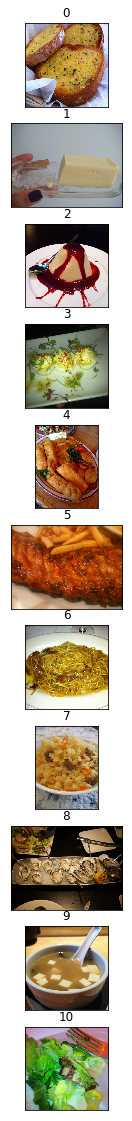

In [25]:
# 查看图片数据
def img_show(img, title='', cmap=None):
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

plt.figure(figsize=(20, 20))
for i in range(11):
    plt.subplot(11, 1, i + 1)
    fig = img_show(plt.imread(f'dataset/food-11/training/{i}_{i*10}.jpg'), title=str(i))

## 划分数据集

In [ ]:
# 统计训练集图片与验证集图片数量
train_Path = 'dataset/food-11/training'
vali_path = 'dataset/food-11/validation'
trainfood_list = os.listdir(train_Path)
valifood_list = os.listdir(vali_path)
random.shuffle(trainfood_list)
random.shuffle(valifood_list)
print(len(trainfood_list))
print(trainfood_list[0:2])
print(len(valifood_list))
print(valifood_list[0:2])

9866
['5_1288.jpg', '9_12.jpg']
3430
['7_14.jpg', '3_222.jpg']


## 获取图片ID与标签

In [ ]:
data_train_list = [] #用1个列表保存每个训练样本的读取路径以及标签
for each in trainfood_list:
    data_train_list.append([each,int(re.findall(r"(\d+)_",each)[0])]) #利用正则表达式获取 _ 前的图片标签
random.shuffle(data_train_list)
print(len(data_train_list))
print(data_train_list[0:3]) #查看打乱顺序后的信息

9866
[['3_836.jpg', 3], ['9_1269.jpg', 9], ['0_44.jpg', 0]]


In [ ]:
data_vali_list = []  # 用个列表保存每个测试样本的读取路径以及标签
for each in valifood_list:
    data_vali_list.append([each,int(re.findall(r"(\d+)_",each)[0])]) #利用正则表达式获取 _ 前的图片标签
print(len(data_vali_list))
print(data_vali_list[0:3])

3430
[['7_14.jpg', 7], ['3_222.jpg', 3], ['9_0.jpg', 9]]


## 数据信息写入文档

这里存储的是相对路径，当前环境是在**PaddleClas**目录下，图片数据保存在根目录**PaddleClas/dataset/food-11**下，保存图片路径时要使用**相对路径**。

同时，在保存图片对应的标签值时，路径与标签之间用空格隔开。

> 例如，保存在train_list.txt中的数据信息：training/3_836.jpg 3


In [ ]:
f = open('dataset/food-11/train_list.txt','w')
for each in data_train_list:
    info = 'training/'+ each[0] + ' ' + str(each[1]) + '\n'
    f.write(info)

In [ ]:
f = open('dataset/food-11/vali_list.txt','w')
for each in data_vali_list:
    info = 'validation/'+each[0] + ' ' + str(each[1]) + '\n'
    f.write(info)

# 训练与验证

## 配置文件

训练之前需要设置配置文件，配置文件都保存在**PaddleClas/configs**文件下。

以**HRNet/HRNet_W64_C.yaml**为例，设置配置文件训练自己的数据集。

**如下图所示，改几个关键地方就可以快速开始训练了，其他的都默认的来。**

![](https://ai-studio-static-online.cdn.bcebos.com/6c24902ce9974f46bbc2a8a4e4a233bc811b63176d7a41dfb89f880073ce965c)


## 开始训练
**使用下面代码直接开始训练， -c 后面要指明配置文件路径，也是相对路径**

**训练三个网络：HRNet_W64_C，SE_ResNeXt101_32x4d，ShuffleNetV2_swish。**

**训练HRNet_W64_C**

In [ ]:
%cd PaddleClas
!python ./tools/train.py -c ./configs/HRNet/HRNet_W64_C.yaml

## 验证模型

**按照下面代码还接开始验证，使用-o 指明需要使用的模型路径，不需要后缀.pdparams**


In [ ]:
# 'top1_acc': 0.8271137029367007
!python tools/eval.py -c ./configs/HRNet/HRNet_W64_C.yaml -o pretrained_model="./output/HRNet_W64_C/best_model/ppcls" \
    -o load_static_weights=False

2021-08-12 09:24:33 WARNING: A new filed (load_static_weights) detected!
2021-08-12 09:24:33 INFO: 
==        PaddleClas is powered by PaddlePaddle !        ==
==                                                       ==
==   For more info please go to the following website.   ==
==                                                       ==
==       https://github.com/PaddlePaddle/PaddleClas      ==

2021-08-12 09:24:33 INFO: ARCHITECTURE : 
2021-08-12 09:24:33 INFO:     name : HRNet_W64_C
2021-08-12 09:24:33 INFO: ------------------------------------------------------------
2021-08-12 09:24:33 INFO: LEARNING_RATE : 
2021-08-12 09:24:33 INFO:     function : Piecewise
2021-08-12 09:24:33 INFO:     params : 
2021-08-12 09:24:33 INFO:         decay_epochs : [30, 60, 90]
2021-08-12 09:24:33 INFO:         gamma : 0.1
2021-08-12 09:24:33 INFO:         lr : 0.1
2021-08-12 09:24:33 INFO: ------------------------------------------------------------
2021-08-12 09:24:33 INFO: OPTIMIZER : 
2021-08-12

**训练SE_ResNeXt101_32x4d**

In [ ]:
!python ./tools/train.py -c ./configs/SENet/SE_ResNeXt101_32x4d.yaml

In [ ]:
# 'top1_acc': 0.8107871721159265
!python tools/eval.py -c ./configs/SENet/SE_ResNeXt101_32x4d.yaml -o pretrained_model="./output/SE_ResNeXt101_32x4d/best_model/ppcls" \
    -o load_static_weights=False

2021-08-12 09:28:09 WARNING: A new filed (load_static_weights) detected!
2021-08-12 09:28:09 INFO: 
==        PaddleClas is powered by PaddlePaddle !        ==
==                                                       ==
==   For more info please go to the following website.   ==
==                                                       ==
==       https://github.com/PaddlePaddle/PaddleClas      ==

2021-08-12 09:28:09 INFO: ARCHITECTURE : 
2021-08-12 09:28:09 INFO:     name : SE_ResNeXt101_32x4d
2021-08-12 09:28:09 INFO: ------------------------------------------------------------
2021-08-12 09:28:09 INFO: LEARNING_RATE : 
2021-08-12 09:28:09 INFO:     function : Cosine
2021-08-12 09:28:09 INFO:     params : 
2021-08-12 09:28:09 INFO:         lr : 0.1
2021-08-12 09:28:09 INFO: ------------------------------------------------------------
2021-08-12 09:28:09 INFO: OPTIMIZER : 
2021-08-12 09:28:09 INFO:     function : Momentum
2021-08-12 09:28:09 INFO:     params : 
2021-08-12 09:28:09 INF

## 恢复训练

训练时意外终止了，使用**paddleclas**恢复训练也很方便。只需要指明需要从哪个epoch回复训练，然后改写一下需要导入的断点模型路径就行了。

> !python ./tools/train.py -c ./configs/ShuffleNet/ShuffleNetV2_swish.yaml -o checkpoints="./output/ShuffleNetV2_swish/200/ppcls" -o last_epoch=200 -o use_gpu=True

**训练ShuffleNetV2_swish**

In [ ]:
# 恢复训练
!python ./tools/train.py -c ./configs/ShuffleNet/ShuffleNetV2_swish.yaml -o checkpoints="./output/ShuffleNetV2_swish/200/ppcls" \
        -o last_epoch=200 \
        -o use_gpu=True

In [23]:
# 'top1_acc': 0.8518950436275138
!python tools/eval.py -c ./configs/ShuffleNet/ShuffleNetV2_swish.yaml -o pretrained_model="./output/ShuffleNetV2_swish/best_model/ppcls" \
    -o load_static_weights=False

2021-08-15 15:35:11 WARNING: A new filed (load_static_weights) detected!
2021-08-15 15:35:11 INFO: 
==        PaddleClas is powered by PaddlePaddle !        ==
==                                                       ==
==   For more info please go to the following website.   ==
==                                                       ==
==       https://github.com/PaddlePaddle/PaddleClas      ==

2021-08-15 15:35:11 INFO: ARCHITECTURE : 
2021-08-15 15:35:11 INFO:     name : ShuffleNetV2_swish
2021-08-15 15:35:11 INFO: ------------------------------------------------------------
2021-08-15 15:35:11 INFO: LEARNING_RATE : 
2021-08-15 15:35:11 INFO:     function : CosineWarmup
2021-08-15 15:35:11 INFO:     params : 
2021-08-15 15:35:11 INFO:         lr : 0.5
2021-08-15 15:35:11 INFO:         warmup_epoch : 5
2021-08-15 15:35:11 INFO: ------------------------------------------------------------
2021-08-15 15:35:11 INFO: OPTIMIZER : 
2021-08-15 15:35:11 INFO:     function : Momentum
2021-08

# 模型预测

In [18]:
!python tools/infer/infer.py \
--image_file 'dataset/food-11/testing'\
--model 'ShuffleNetV2_swish'\
--pretrained_model 'output/ShuffleNetV2_swish/best_model/ppcls'\
--pre_label_image True\
--pre_label_out_idr './infer_output'\
--class_num 11

# 效果展示

In [19]:
food_class = { 0:"面包",1:"乳制品",2:"甜点",3:"鸡蛋",4:"油炸食品",
               5:"肉类",6:"面条/意大利面",7:"米饭",8:"海鲜",9:"汤",10:"蔬菜/水果" }

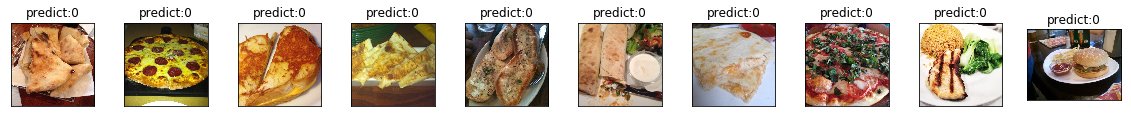

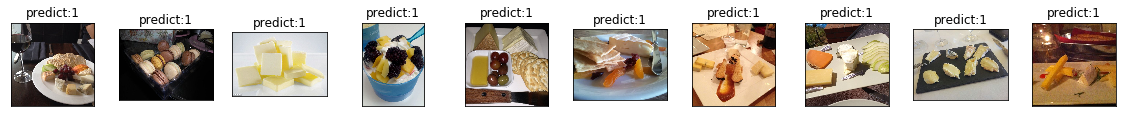

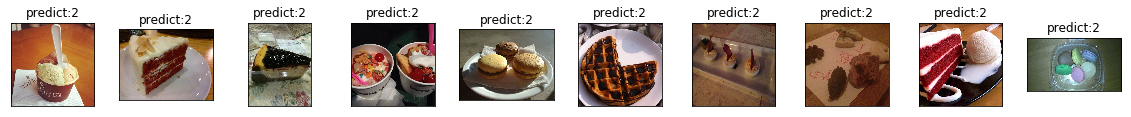

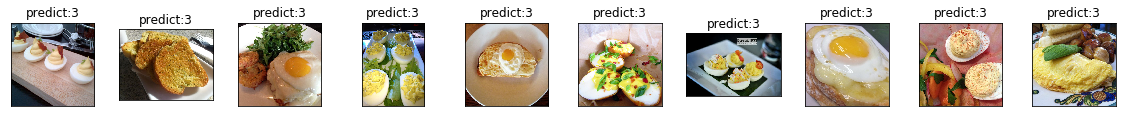

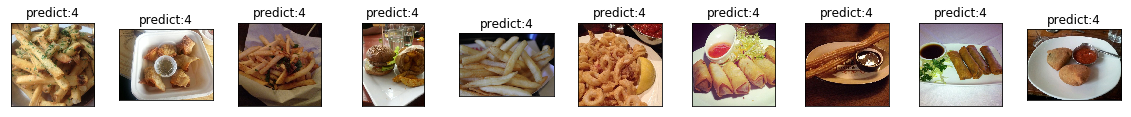

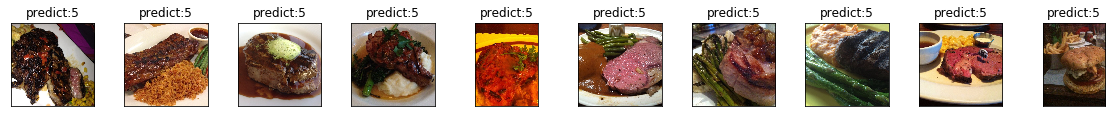

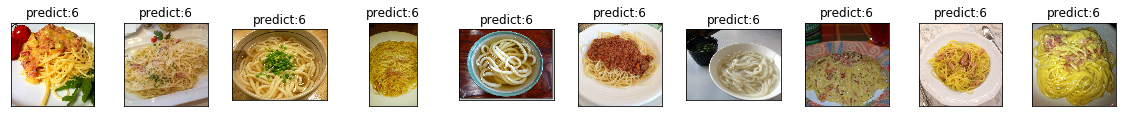

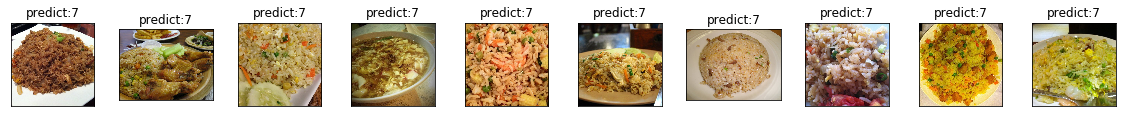

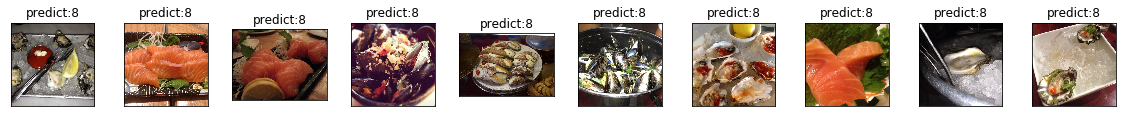

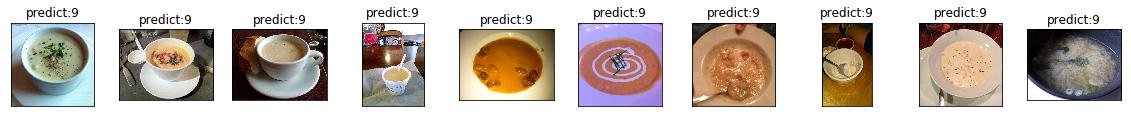

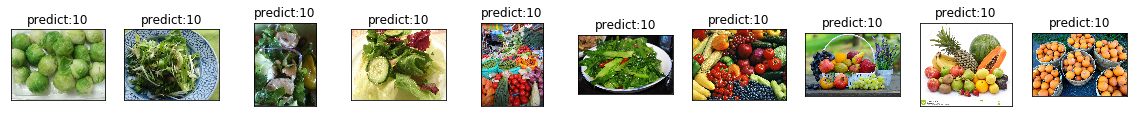

In [22]:
#查看预测结果
def img_show(img, title='', cmap=None):
    fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)

for i in range(11):
    plt.figure(figsize=(20, 20))
    img_list = os.listdir('infer_output/{}'.format(str(i)))
    random.shuffle(img_list)
    for j in range(10):
        img_path = 'infer_output/' + str(i) +'/'+ img_list[j]
        plt.subplot(11, 10, 10*i + j+1)
        fig = img_show(plt.imread(img_path),title='predict:{}'.format(str(i)))


# 总结
使用paddleclas快速进行图像分类网络训练，训练了三个网络：**HRNet_W64_C，SE_ResNeXt101_32x4d，ShuffleNetV2_swish**。

选用验证准确率最高的模型**ShuffleNetV2_swish**进行推理预测，进行预测效果展示
